In [1]:
from datetime import datetime, timedelta, timezone
from IPython.display import clear_output
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
import numpy as np
import pyautogui
import math
import time

pd.options.display.float_format = '{:,.2f}'.format

# Download data

### Fetching tickers from nasdaq and filtering out ETFs and stocks that we have a problem getting their prices

In [2]:
def get_all_tickers(etf=False):
    # Get a list of all available tickers from Yahoo Finance
    all_tickers = web.get_nasdaq_symbols()
    all_tickers = all_tickers[~all_tickers["Test Issue"]]  # Filter out stocks that we can't fetch their data for some reason

    if not etf:
        all_tickers = all_tickers[~all_tickers["ETF"]]  # Filter out ETFs
    tickers = all_tickers.index.tolist()
    return [str(ticker) for ticker in tickers if str(ticker).isalpha()]

In [3]:
def get_data(tickers_list, p="max"):
    return yf.download(tickers_list, period=p, interval="1d")

In [4]:
tickers = get_all_tickers()[:20]
# tickers = ["TSLA", "AAPL", "MSFT", "NVDA", "GOOG", "AACI"]
data = get_data(tickers)

[*********************100%%**********************]  20 of 20 completed


In [5]:
data_cop = data.copy()

In [6]:
new_df = pd.DataFrame(index=data_cop.index.year.unique(), columns=data_cop.columns)
new_df.drop("Adj Close", axis=1, level=0, inplace=True)
new_df["Volume"] = data_cop["Volume"].groupby(data_cop.index.year).mean()
new_df["Close"] = data_cop["Close"].groupby(data_cop.index.year).last()
new_df["Open"] = data_cop["Open"].groupby(data_cop.index.year).first()
new_df["High"] = data_cop["High"].groupby(data_cop.index.year).max()
new_df["Low"] = data_cop["Low"].groupby(data_cop.index.year).min()
for stock in new_df["Close"].columns:
    new_df["Change", stock] = np.nan
new_df["Change"] = new_df.xs("Close", axis=1, level=0).pct_change() * 100

In [7]:
stocks_checklist = pd.DataFrame(index=new_df["Close"].columns, columns=["Years up", "Div yield", "Sector", "avg daily vol", "Total Revenue Incr", "Gross Margin", "Gross Profit Incr", "Trading years"])

stocks_checklist

,Years up,Div yield,Sector,avg daily vol,Total Revenue Incr,Gross Margin,Gross Profit Incr,Trading years
A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AACG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AACI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AACIU,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AACIW,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AACT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AADI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AAGR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AAGRW,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
stocks_checklist = pd.DataFrame(index=new_df["Close"].columns, columns=["Years up", "Div yield", "Sector", "avg daily vol", "Total Revenue Incr", "Gross Margin", "Gross Profit Incr", "Trading years"])

tickers = list(new_df["Close"].columns)  # In case some of the tickers failed, this is the ticker list straight from the returned df
# Years up in a row
tmp = new_df["Change"].copy().iloc[::-1]
tmp.fillna(-1, inplace=True)
neg_year = tmp.apply(lambda x: x[x < 0].index[0] if any(x<0) else None)
current_year = tmp.index[0]
stocks_checklist["Years up"] = current_year - neg_year.copy()
# stocks_checklist["Years up"] = 1
stocks_checklist["avg daily vol"] = new_df["Volume"].copy().iloc[-1:].mean()
stocks_checklist["avg daily vol"] = stocks_checklist["avg daily vol"].fillna(0)

# Eliminate by avg daily vol, so it'll be faster
stocks_checklist = stocks_checklist[stocks_checklist["avg daily vol"] > 40000]

# Div yield
print(f"0/{len(stocks_checklist.index)}")
i = 1
for ticker in stocks_checklist.index:
    clear_output(wait=True)
    print(ticker)
    print(f"{i}/{len(stocks_checklist.index)}")
    i += 1
    tmp = yf.Ticker(ticker)
    start_date = (datetime.now() - timedelta(days = 365))
    start_date = start_date.replace(tzinfo=timezone.utc)
    div_sum = tmp.dividends.loc[start_date:].sum()
    close_price = new_df["Close"][ticker].iloc[-1]
    div_yield = (div_sum/close_price) * 100
    stocks_checklist.loc[ticker, "Div yield"] = div_yield
    # Sector
    if "sector" in tmp.info:
        stocks_checklist.loc[ticker, "Sector"] = tmp.info["sector"]
    
    if "Gross Profit" in tmp.income_stmt.index:
        # Average Gross margin over the last 3 income statements
        if tmp.income_stmt.loc["Total Revenue"].all() > 0:
            stocks_checklist.loc[ticker, "Gross Margin"] = ((tmp.income_stmt.loc["Gross Profit"].iloc[::-1] / tmp.income_stmt.loc["Total Revenue"].iloc[::-1]) * 100).mean()  # Gross margin of the last 3 years
        
        # Gross profit increase percentage over the last 3 years (3 income statements)
        stocks_checklist.loc[ticker, "Gross Profit Incr"] = tmp.income_stmt.loc["Gross Profit"].iloc[::-1].pct_change().mean() * 100
    
    # Total Revenue increase percentage over the last 3 years (3 income statements)
    stocks_checklist.loc[ticker, "Total Revenue Incr"] = tmp.income_stmt.loc["Total Revenue"].iloc[::-1].pct_change().mean() * 100
    
    # How long the stock is trading for
    if "firstTradeDateEpochUtc" in tmp.info:
        tmp.info
        epoch = tmp.info["firstTradeDateEpochUtc"]
        if epoch > 0:
            fty = datetime.fromtimestamp(tmp.info["firstTradeDateEpochUtc"]).year  # First trade year
        else:
            fty = (datetime(1970, 1, 1) + timedelta(seconds=epoch)).year
        stocks_checklist.loc[ticker, "Trading years"] = current_year - fty
    
stocks_checklist["Div yield"].replace(0.0, np.nan, inplace=True)

AAU
13/13


In [9]:
# stocks_checklist["avg daily vol"].fillna(0, inplace=True)
stocks_checklist

,Years up,Div yield,Sector,avg daily vol,Total Revenue Incr,Gross Margin,Gross Profit Incr,Trading years
A,0,0.70,Healthcare,"1,641,677.78",8.84,53.03,7.48,25
AA,0,1.33,Basic Materials,"5,312,355.56",16.66,18.95,51.19,62
AACT,1,NaN,Financial Services,"49,822.78",NaN,NaN,NaN,1
AADI,0,NaN,Healthcare,"445,270.30",664.37,95.61,"1,288.10",6
AAGR,0,NaN,Consumer Defensive,"403,916.30",inf,NaN,-inf,3
AAL,0,NaN,Industrials,"42,581,300.00",68.12,-7.71,"16,635.00",19
AAN,0,4.86,Industrials,"265,787.10",14.13,58.98,3.60,4
AAOI,0,NaN,Technology,"3,070,822.22",-2.25,18.15,-18.11,11
AAON,0,0.57,Industrials,"296,577.10",35.08,27.60,30.40,32
AAP,1,3.67,Consumer Cyclical,"1,409,511.11",5.12,44.55,5.33,23


# Scoring

In [47]:
def gaussian(x, peak):
    # exp = peak * np.exp(-(x - mu)**2 / (2 * sigma**2))
    # right_side = (A * np.exp(-(x + mu)**2 / (2 * sigma_right**2)) + 10)
    lim = (-4/(x*0.6)) + peak
    return np.where(lim > 0.3, lim, 0.3)

In [48]:
peak = 10  # Y peak value - Max score for each scoring category
tmp = stocks_checklist["Div yield"].dropna()
div_values = np.array(tmp.values)
div_stocks = np.array(tmp.index)
med = np.median(div_values)
div_scores = gaussian(div_values, peak)

C:\Users\sasso\AppData\Local\Temp\ipykernel_1556\1069746088.py:4: RuntimeWarning: divide by zero encountered in divide
  lim = (-4/(x*0.6)) + peak


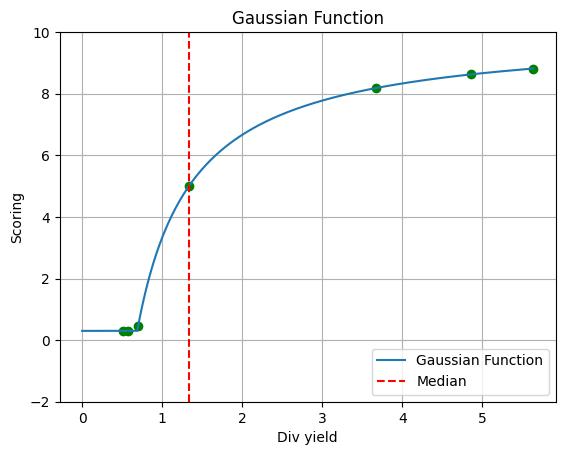

In [49]:
x_values = np.linspace(0, max(div_values), 5000)  # Generating 1000 values between 0 and 4
y_values = gaussian(x_values, peak)  # Calculate corresponding y values using the Gaussian function
# y_values = asymmetric_gaussian_sigmoid(x_values, mu, sigma_left, slope, offset)

# Plot the function
plt.plot(x_values, y_values, label=f'Gaussian Function')
plt.ylim(-2, 10)  # Adjust these limits according to your needs

plt.scatter(div_values, div_scores, color='green', marker='o')
plt.axvline(med, color="red", linestyle="--", label="Median")
plt.title('Gaussian Function')
plt.xlabel('Div yield')
plt.ylabel('Scoring')
plt.legend()
plt.grid(True)

In [50]:
max(div_values)

5.63380274352112

In [51]:
scores = pd.DataFrame(index=stocks_checklist.index, columns=stocks_checklist.columns)
scores.loc[div_stocks, "Div yield"] = div_scores
scores

,Years up,Div yield,Sector,avg daily vol,Total Revenue Incr,Gross Margin,Gross Profit Incr,Trading years
A,NaN,0.45,NaN,NaN,NaN,NaN,NaN,NaN
AA,NaN,4.99,NaN,NaN,NaN,NaN,NaN,NaN
AACT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AADI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AAGR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AAL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AAN,NaN,8.63,NaN,NaN,NaN,NaN,NaN,NaN
AAOI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AAON,NaN,0.30,NaN,NaN,NaN,NaN,NaN,NaN
AAP,NaN,8.18,NaN,NaN,NaN,NaN,NaN,NaN


In [33]:
a = stocks_checklist["Div yield"].dropna()
np.array(a.values)
stocks = np.array(a.index)


array(['A', 'AA', 'AAN', 'AAON', 'AAP', 'AAPL', 'AAT'], dtype=object)